<a href="https://colab.research.google.com/github/mukeshkharel/Flowise/blob/main/PilotNet_udacity_self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Bibliotheken installieren

In [ ]:
!pip install grad-cam

import os
import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f7fbd29865db38808951bfe0e7b1d5df874ec797f72795975ebc9cd7a3fbf6cf
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


A. Datensatz herunterladen (Udacity)

In [ ]:
print("Lade Udacity Datensatz herunter (ca. 300MB)...")
if not os.path.exists('data'):
    !wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
    !unzip -q data.zip
    print("Download und Entpacken fertig!")
else:
    print("Daten bereits vorhanden.")

Lade Udacity Datensatz herunter (ca. 300MB)...
--2026-02-06 03:19:43--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 18.64.156.70, 18.64.156.149, 18.64.156.22, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|18.64.156.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 317.70M  32.2MB/s    in 4.7s    

2026-02-06 03:19:48 (67.2 MB/s) - ‘data.zip’ saved [333137665/333137665]

Download und Entpacken fertig!


In [ ]:
B. Daten vorbereiten (Regression -> Klassifikation)

SyntaxError: invalid syntax (ipython-input-2239560279.py, line 1)

In [ ]:
# Wir lesen das Log-File
log_path = 'data/driving_log.csv'
cols = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
df = pd.read_csv(log_path, names=cols, skiprows=1)

# Wir definieren Klassen basierend auf dem Lenkwinkel
# < -0.15 = Links (0)
# > 0.15 = Rechts (2)
# Dazwischen = Geradeaus (1)
def map_steering_to_class(angle):
    if angle < -0.1:
        return 0 # Links
    elif angle > 0.1:
        return 2 # Rechts
    else:
        return 1 # Geradeaus

df['class'] = df['steering'].apply(map_steering_to_class)

# Wir balancieren die Daten etwas (Geradeaus kommt zu oft vor)
df_straight = df[df['class'] == 1].sample(frac=0.3) # Nur 30% der Geraden behalten
df_turns = df[df['class'] != 1]
df_balanced = pd.concat([df_straight, df_turns])

print(f"Datensatz Größe: {len(df_balanced)} Bilder")
print(f"Verteilung: {df_balanced['class'].value_counts().to_dict()}")

# Split in Train/Val
train_df, val_df = train_test_split(df_balanced, test_size=0.2)

Datensatz Größe: 3890 Bilder
Verteilung: {1: 1777, 2: 1176, 0: 937}


C. Custom Dataset Klasse

In [ ]:
class UdacityDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Bildpfad aus CSV lesen (Pfade im CSV sind absolut, wir brauchen nur Dateinamen)
        row = self.dataframe.iloc[idx]
        img_name = row['center'].split('/')[-1]
        img_path = os.path.join(self.root_dir, 'IMG', img_name)

        image = Image.open(img_path).convert('RGB')
        label = int(row['class'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformationen (PilotNet Größe)
transforms_def = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor(),
    # Keine Normalisierung für einfachere Visualisierung, oder Standard:
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = UdacityDataset(train_df, 'data', transform=transforms_def)
val_set = UdacityDataset(val_df, 'data', transform=transforms_def)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

D. PilotNet Modell (Klassifikation)

In [ ]:
class PilotNetClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(PilotNetClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(1152, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

E. Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PilotNetClassifier(num_classes=3).to(device) # 3 Klassen: Links, Gerade, Rechts
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starte Training auf Udacity Daten...")
for epoch in range(5): # 5 Epochen reichen oft schon für gute Ergebnisse
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

Starte Training auf Udacity Daten...
Epoch 1 Loss: 1.0784
Epoch 2 Loss: 1.0412
Epoch 3 Loss: 0.8268
Epoch 4 Loss: 0.7131
Epoch 5 Loss: 0.6583


F. Grad-CAM Visualisierung

Visualisiere Ergebnisse...


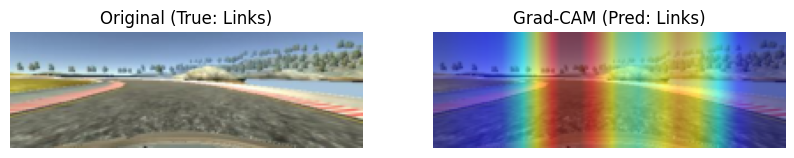

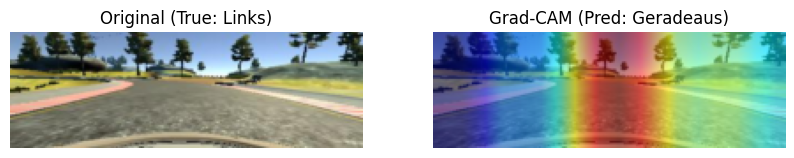

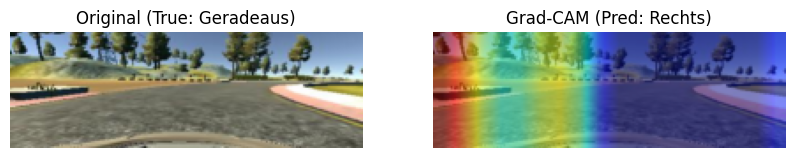

In [ ]:
def visualize_udacity(model, dataset):
    model.eval()
    # Nimm ein zufälliges Bild aus dem Validation Set
    idx = np.random.randint(0, len(dataset))
    img_tensor, label = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # Prediction
    output = model(input_tensor)
    pred_idx = torch.argmax(output).item()
    classes = ['Links', 'Geradeaus', 'Rechts']

    # Grad-CAM
    target_layers = [model.features[-2]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Bild denormalisieren für Anzeige
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    rgb_img = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rgb_img)
    plt.title(f"Original (True: {classes[label]})")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(visualization)
    plt.title(f"Grad-CAM (Pred: {classes[pred_idx]})")
    plt.axis('off')
    plt.show()

# Zeige 3 Beispiele
print("Visualisiere Ergebnisse...")
for _ in range(3):
    visualize_udacity(model, val_set)